# Match de Vagas com Deep Learning e NLP
Autor: Caio Saldanha

Realizado no Google Collab com GPU NVIDIA Tesla T4

## 1. Importação de Bibliotecas

In [ ]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import gc
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas para NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import RSLPStemmer
import spacy

# Bibliotecas para Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Bibliotecas para Transformers e Embeddings
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

# Bibliotecas para visualização e métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go

## 2. Configuração do Ambiente NLP

 Preparação das ferramentas de NLP (NLTK e spaCy) e o modelo de embedding (Sentence Transformers) que serão utilizados nas etapas subsequentes

In [23]:
# Download dos recursos do NLTK
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Configuração do spaCy para português
try:
    nlp = spacy.load('pt_core_news_sm')
    print("Modelo spaCy 'pt_core_news_sm' carregado com sucesso!")
except OSError:
    print("Modelo spaCy 'pt_core_news_sm' não encontrado. Tentando baixar...")
    try:
        import spacy.cli
        spacy.cli.download('pt_core_news_sm')
        nlp = spacy.load('pt_core_news_sm')
        print("Modelo spaCy 'pt_core_news_sm' baixado e carregado com sucesso!")
    except Exception as e:
        print(f"Erro ao baixar ou carregar modelo spaCy: {e}")
        nlp = None

# Inicialização do modelo de sentence embeddings
print("Carregando modelo de sentence transformers...")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
print("Modelo carregado com sucesso!")

Modelo spaCy 'pt_core_news_sm' não encontrado. Tentando baixar...
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Modelo spaCy 'pt_core_news_sm' baixado e carregado com sucesso!
Carregando modelo de sentence transformers...
Modelo carregado com sucesso!


## 3. Carregamento e Exploração dos Dados

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Carregamento dos dados JSON
with open("/content/drive/MyDrive/fiap/tech-challenge-f5/data-files/applicants.json", 'r', encoding='utf-8') as f:
    applicants_data = json.load(f)

with open("/content/drive/MyDrive/fiap/tech-challenge-f5/data-files/prospects.json", 'r', encoding='utf-8') as f:
    prospects_data = json.load(f)

with open("/content/drive/MyDrive/fiap/tech-challenge-f5/data-files/vagas.json", 'r', encoding='utf-8') as f:
    vagas_data = json.load(f)

print(f"Candidatos carregados: {len(applicants_data)}")
print(f"Prospects carregados: {len(prospects_data)}")
print(f"Vagas carregadas: {len(vagas_data)}")

Candidatos carregados: 42482
Prospects carregados: 14222
Vagas carregadas: 14081


## 4. Extração e Estruturação de Dados Textuais

In [25]:
# Função para extrair textos dos CVs dos candidatos
def extract_candidate_texts(applicants_data):
    candidate_texts = []

    for candidate_id, candidate_info in applicants_data.items():
        # Extrair informações textuais relevantes
        texts = []

        # CV em português e inglês
        if 'cv_pt' in candidate_info and candidate_info['cv_pt']:
            texts.append(candidate_info['cv_pt'])
        if 'cv_en' in candidate_info and candidate_info['cv_en']:
            texts.append(candidate_info['cv_en'])

        # Objetivo profissional
        if 'infos_basicas' in candidate_info and 'objetivo_profissional' in candidate_info['infos_basicas']:
            obj_prof = candidate_info['infos_basicas']['objetivo_profissional']
            if obj_prof:
                texts.append(obj_prof)

        # Conhecimentos técnicos
        if 'informacoes_profissionais' in candidate_info:
            prof_info = candidate_info['informacoes_profissionais']
            if 'conhecimentos_tecnicos' in prof_info and prof_info['conhecimentos_tecnicos']:
                texts.append(prof_info['conhecimentos_tecnicos'])

        # Combinar todos os textos do candidato
        combined_text = ' '.join([str(text) for text in texts if text and str(text).strip()])

        candidate_texts.append({
            'candidate_id': candidate_id,
            'text': combined_text
        })

    return candidate_texts

# Função para extrair textos das vagas
def extract_job_texts(vagas_data):
    job_texts = []

    for job_id, job_info in vagas_data.items():
        texts = []

        # Título da vaga
        if 'infos_basicas' in job_info and 'titulo_vaga' in job_info['infos_basicas']:
            titulo = job_info['infos_basicas']['titulo_vaga']
            if titulo:
                texts.append(titulo)

        # Objetivo da vaga
        if 'infos_basicas' in job_info and 'objetivo_vaga' in job_info['infos_basicas']:
            objetivo = job_info['infos_basicas']['objetivo_vaga']
            if objetivo:
                texts.append(objetivo)

        # Principais atividades
        if 'perfil_vaga' in job_info and 'principais_atividades' in job_info['perfil_vaga']:
            atividades = job_info['perfil_vaga']['principais_atividades']
            if atividades:
                texts.append(atividades)

        # Competências técnicas
        if 'perfil_vaga' in job_info and 'competencia_tecnicas_e_comportamentais' in job_info['perfil_vaga']:
            competencias = job_info['perfil_vaga']['competencia_tecnicas_e_comportamentais']
            if competencias:
                texts.append(competencias)

        # Combinar todos os textos da vaga
        combined_text = ' '.join([str(text) for text in texts if text and str(text).strip()])

        job_texts.append({
            'job_id': job_id,
            'text': combined_text
        })

    return job_texts

# Extrair textos
candidate_texts = extract_candidate_texts(applicants_data)
job_texts = extract_job_texts(vagas_data)

print(f"Textos de candidatos extraídos: {len(candidate_texts)}")
print(f"Textos de vagas extraídos: {len(job_texts)}")

# Mostrar exemplos
print("\n--- Exemplo de texto de candidato ---")
if candidate_texts and candidate_texts[0]['text']:
    print(candidate_texts[0]['text'][:500] + "...")

print("\n--- Exemplo de texto de vaga ---")
if job_texts and job_texts[0]['text']:
    print(job_texts[0]['text'][:500] + "...")

Textos de candidatos extraídos: 42482
Textos de vagas extraídos: 14081

--- Exemplo de texto de candidato ---
assistente administrativo


santosbatista
itapecerica da serra/sp
29 anos ▪ brasileiro ▪ casado
formação acadêmica
 bacharel - ciências contábeis
centro universitário ítalo brasileiro
jul/2015 - dez/2018
 graduação - gestão financeira
centro universitário anhanguera
jan/2013 - dez/2014
habilidades
 contas a pagar e receber
 excel avançado
 indicadores kpi’s
 notas fiscais, cfop’s
 fechamento contábil
 emissão de boletos
 guias
 impostos
 budget
 controladoria
 sistemas integrados:
t...

--- Exemplo de texto de vaga ---
Operations Lead

Roles & Responsibilities:
• The Operations Manager is accountable for delivering the run services towards a client or a specific set of clients.
• The Operations Manager has a firm working relation with the SDM who is accountable for the overall contractual compliance of all services and projects.
• Responsible for the delivery of th

## 5. Pré-processamento de Texto

In [26]:
import string

# Função de pré-processamento de texto
def preprocess_text(text):
    if not text or not isinstance(text, str):
        return ""

    # Converter para minúsculas
    text = text.lower()

    # Remover pontuação
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remover números (opcional)
    text = re.sub(r'\d+', '', text)

    # Remover espaços extras
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Função para remover stopwords
def remove_stopwords(text):
    try:
        stop_words = set(stopwords.words('portuguese'))
        word_tokens = word_tokenize(text)
        filtered_text = [word for word in word_tokens if word not in stop_words]
        return ' '.join(filtered_text)
    except:
        return text

# Aplicar pré-processamento
print("Aplicando pré-processamento...")

for candidate in candidate_texts:
    candidate['processed_text'] = preprocess_text(candidate['text'])
    candidate['clean_text'] = remove_stopwords(candidate['processed_text'])

for job in job_texts:
    job['processed_text'] = preprocess_text(job['text'])
    job['clean_text'] = remove_stopwords(job['processed_text'])

print("Pré-processamento concluído!")

# Verificar resultado do pré-processamento
print("\n--- Exemplo após pré-processamento ---")
if candidate_texts[0]['clean_text']:
    print("Candidato:", candidate_texts[0]['clean_text'][:200] + "...")
if job_texts[0]['clean_text']:
    print("Vaga:", job_texts[0]['clean_text'][:200] + "...")

Aplicando pré-processamento...
Pré-processamento concluído!

--- Exemplo após pré-processamento ---
Candidato: assistente administrativo santosbatista itapecerica da serrasp anos ▪ brasileiro ▪ casado formação acadêmica  bacharel ciências contábeis centro universitário ítalo brasileiro jul dez  graduação ges...
Vaga: operations lead roles responsibilities • the operations manager is accountable for delivering the run services towards a client or a specific set of clients • the operations manager has a firm working...


## 6. Geração de Embeddings Semânticos

In [7]:
# Função para gerar embeddings usando sentence transformers
def generate_embeddings(texts, model, device, batch_size=128):
    """
    Gera embeddings semânticos para uma lista de textos usando o dispositivo especificado - 1024 batch size usa 7gb GPU Ram Tesla T4
    """
    # Filtrar textos vazios
    valid_texts = [text if text and len(text.strip()) > 0 else "texto vazio" for text in texts]

    # Mover o modelo para o dispositivo especificado
    model.to(device)

    # Gerar embeddings
    embeddings = model.encode(valid_texts, show_progress_bar=True, device=device, batch_size=batch_size)

    return embeddings

# Extrair textos para embeddings
candidate_texts_for_embedding = [candidate['clean_text'] for candidate in candidate_texts]
job_texts_for_embedding = [job['clean_text'] for job in job_texts]

# Definir o dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo para embeddings: {device}")


print("Gerando embeddings para candidatos...")
candidate_embeddings = generate_embeddings(candidate_texts_for_embedding, sentence_model, device)

print("Gerando embeddings para vagas...")
job_embeddings = generate_embeddings(job_texts_for_embedding, sentence_model, device)

print(f"Embeddings de candidatos: {candidate_embeddings.shape}")
print(f"Embeddings de vagas: {job_embeddings.shape}")

# Adicionar embeddings aos dados
for i, candidate in enumerate(candidate_texts):
    candidate['embedding'] = candidate_embeddings[i]

for i, job in enumerate(job_texts):
    job['embedding'] = job_embeddings[i]

Usando dispositivo para embeddings: cuda
Gerando embeddings para candidatos...


Batches:   0%|          | 0/332 [00:00<?, ?it/s]

Gerando embeddings para vagas...


Batches:   0%|          | 0/111 [00:00<?, ?it/s]

Embeddings de candidatos: (42482, 384)
Embeddings de vagas: (14081, 384)


## 7. Análise de Similaridade Semântica

In [8]:
# Função para calcular similaridade entre candidatos e vagas
def calculate_semantic_similarity(candidate_embeddings, job_embeddings):
    """
    Calcula a matriz de similaridade semântica entre candidatos e vagas
    """
    similarity_matrix = cosine_similarity(candidate_embeddings, job_embeddings)
    return similarity_matrix

# Calcular matriz de similaridade
print("Calculando matriz de similaridade semântica...")
similarity_matrix = calculate_semantic_similarity(candidate_embeddings, job_embeddings)

print(f"Matriz de similaridade: {similarity_matrix.shape}")
print(f"Similaridade média: {similarity_matrix.mean():.4f}")
print(f"Similaridade máxima: {similarity_matrix.max():.4f}")
print(f"Similaridade mínima: {similarity_matrix.min():.4f}")

Calculando matriz de similaridade semântica...
Matriz de similaridade: (42482, 14081)
Similaridade média: 0.3422
Similaridade máxima: 1.0000
Similaridade mínima: -0.2687


## 8. Visualização da Similaridade

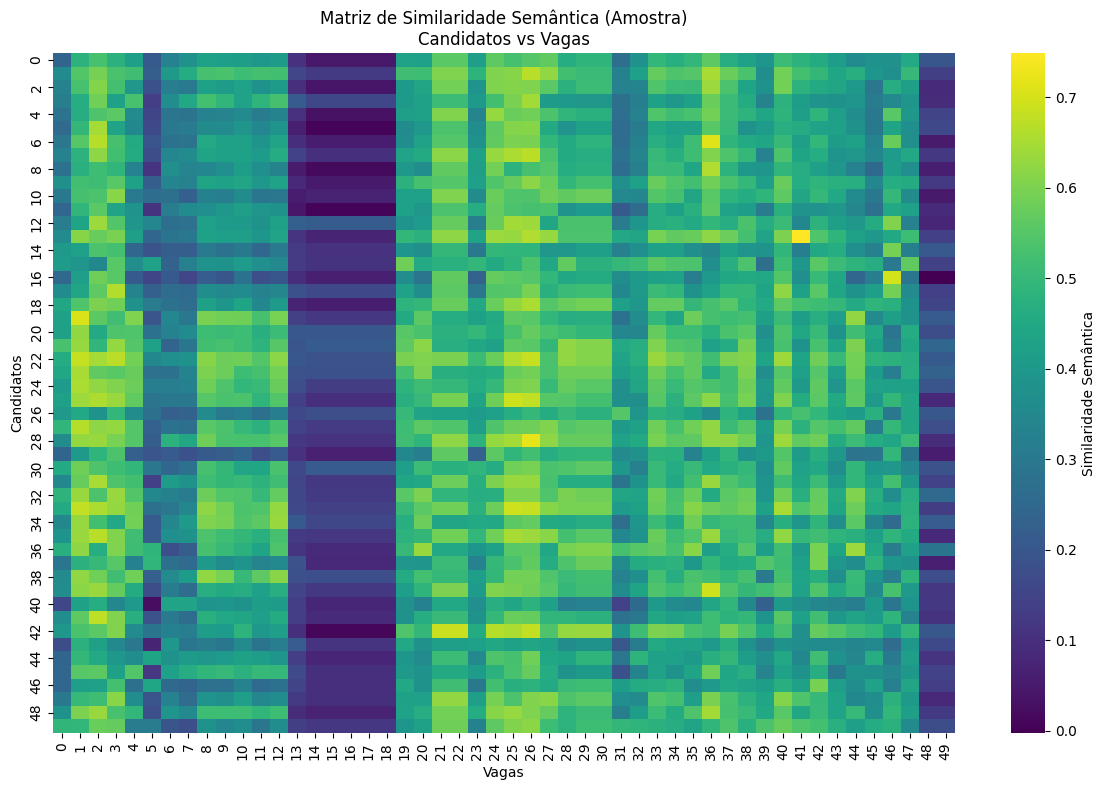

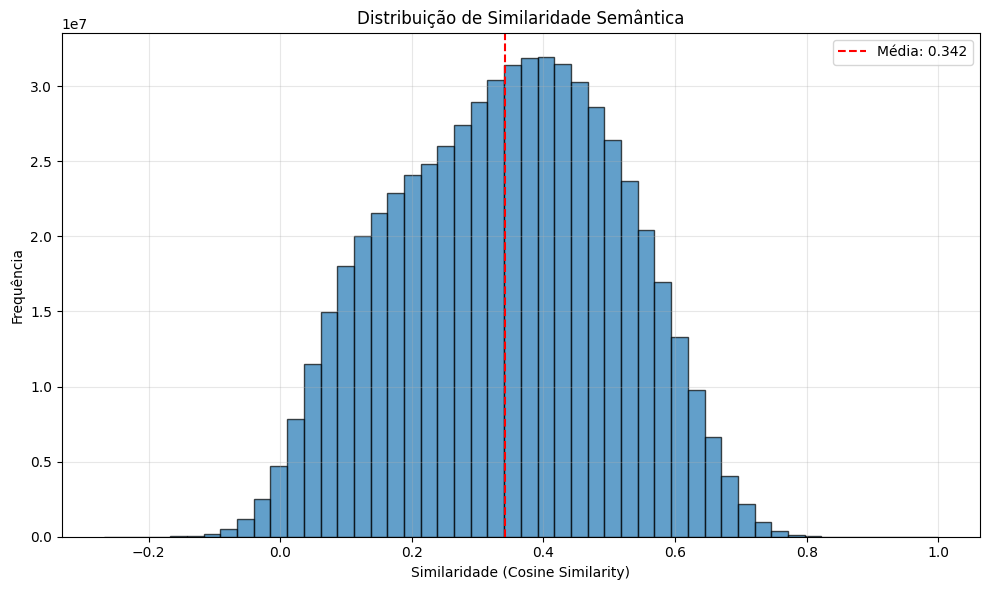

In [9]:
# Criar heatmap da matriz de similaridade (amostra)
plt.figure(figsize=(12, 8))

# Selecionar uma amostra para visualização (primeiros 50x50)
sample_size = min(50, similarity_matrix.shape[0], similarity_matrix.shape[1])
sample_matrix = similarity_matrix[:sample_size, :sample_size]

sns.heatmap(sample_matrix,
            cmap='viridis',
            cbar_kws={'label': 'Similaridade Semântica'})
plt.title('Matriz de Similaridade Semântica (Amostra)\nCandidatos vs Vagas')
plt.xlabel('Vagas')
plt.ylabel('Candidatos')
plt.tight_layout()
plt.show()

# Histograma de distribuição de similaridade
plt.figure(figsize=(10, 6))
plt.hist(similarity_matrix.flatten(), bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribuição de Similaridade Semântica')
plt.xlabel('Similaridade (Cosine Similarity)')
plt.ylabel('Frequência')
plt.axvline(similarity_matrix.mean(), color='red', linestyle='--', label=f'Média: {similarity_matrix.mean():.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Sistema de Recomendação por Similaridade

In [10]:
# Função para recomendar candidatos para uma vaga
def recommend_candidates_for_job(job_index, similarity_matrix, candidate_texts, top_k=10):
    """
    Recomenda os top-k candidatos mais similares para uma vaga específica
    """
    # Obter similaridades para a vaga específica
    job_similarities = similarity_matrix[:, job_index]

    # Ordenar candidatos por similaridade (decrescente)
    candidate_indices = np.argsort(job_similarities)[::-1][:top_k]

    recommendations = []
    for idx in candidate_indices:
        recommendations.append({
            'candidate_id': candidate_texts[idx]['candidate_id'],
            'similarity_score': job_similarities[idx],
            'candidate_text_preview': candidate_texts[idx]['text'][:200] + "..."
        })

    return recommendations

# Função para recomendar vagas para um candidato
def recommend_jobs_for_candidate(candidate_index, similarity_matrix, job_texts, top_k=10):
    """
    Recomenda as top-k vagas mais similares para um candidato específico
    """
    # Obter similaridades para o candidato específico
    candidate_similarities = similarity_matrix[candidate_index, :]

    # Ordenar vagas por similaridade (decrescente)
    job_indices = np.argsort(candidate_similarities)[::-1][:top_k]

    recommendations = []
    for idx in job_indices:
        recommendations.append({
            'job_id': job_texts[idx]['job_id'],
            'similarity_score': candidate_similarities[idx],
            'job_text_preview': job_texts[idx]['text'][:200] + "..."
        })

    return recommendations

# Exemplo de recomendações
print("=== EXEMPLO DE RECOMENDAÇÕES ===")
print("\n1. Top 5 candidatos para a primeira vaga:")
job_recommendations = recommend_candidates_for_job(0, similarity_matrix, candidate_texts, top_k=5)
for i, rec in enumerate(job_recommendations, 1):
    print(f"{i}. Candidato {rec['candidate_id']} - Similaridade: {rec['similarity_score']:.4f}")

print("\n2. Top 5 vagas para o primeiro candidato:")
candidate_recommendations = recommend_jobs_for_candidate(0, similarity_matrix, job_texts, top_k=5)
for i, rec in enumerate(candidate_recommendations, 1):
    print(f"{i}. Vaga {rec['job_id']} - Similaridade: {rec['similarity_score']:.4f}")

=== EXEMPLO DE RECOMENDAÇÕES ===

1. Top 5 candidatos para a primeira vaga:
1. Candidato 27124 - Similaridade: 0.6766
2. Candidato 37780 - Similaridade: 0.6500
3. Candidato 38394 - Similaridade: 0.6471
4. Candidato 7303 - Similaridade: 0.6290
5. Candidato 688 - Similaridade: 0.6272

2. Top 5 vagas para o primeiro candidato:
1. Vaga 14113 - Similaridade: 0.7912
2. Vaga 13468 - Similaridade: 0.7891
3. Vaga 14199 - Similaridade: 0.7891
4. Vaga 13277 - Similaridade: 0.7891
5. Vaga 13696 - Similaridade: 0.7891


## 10. Clustering de Candidatos e Vagas

In [11]:
# Clustering de candidatos
def perform_clustering(embeddings, n_clusters=5, random_state=42):
    """
    Realiza clustering dos embeddings
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)
    return cluster_labels, kmeans

# Clustering de candidatos
print("Realizando clustering de candidatos...")
candidate_clusters, candidate_kmeans = perform_clustering(candidate_embeddings, n_clusters=8)

# Clustering de vagas
print("Realizando clustering de vagas...")
job_clusters, job_kmeans = perform_clustering(job_embeddings, n_clusters=5)

# Análise dos clusters
print(f"\nDistribuição de candidatos por cluster:")
candidate_cluster_counts = Counter(candidate_clusters)
for cluster, count in sorted(candidate_cluster_counts.items()):
    print(f"Cluster {cluster}: {count} candidatos")

print(f"\nDistribuição de vagas por cluster:")
job_cluster_counts = Counter(job_clusters)
for cluster, count in sorted(job_cluster_counts.items()):
    print(f"Cluster {cluster}: {count} vagas")

Realizando clustering de candidatos...
Realizando clustering de vagas...

Distribuição de candidatos por cluster:
Cluster 0: 4252 candidatos
Cluster 1: 1935 candidatos
Cluster 2: 3663 candidatos
Cluster 3: 2280 candidatos
Cluster 4: 12746 candidatos
Cluster 5: 748 candidatos
Cluster 6: 10158 candidatos
Cluster 7: 6700 candidatos

Distribuição de vagas por cluster:
Cluster 0: 2877 vagas
Cluster 1: 2065 vagas
Cluster 2: 4794 vagas
Cluster 3: 2450 vagas
Cluster 4: 1895 vagas


## 11. Visualização t-SNE dos Embeddings

Aplicando t-SNE para candidatos...


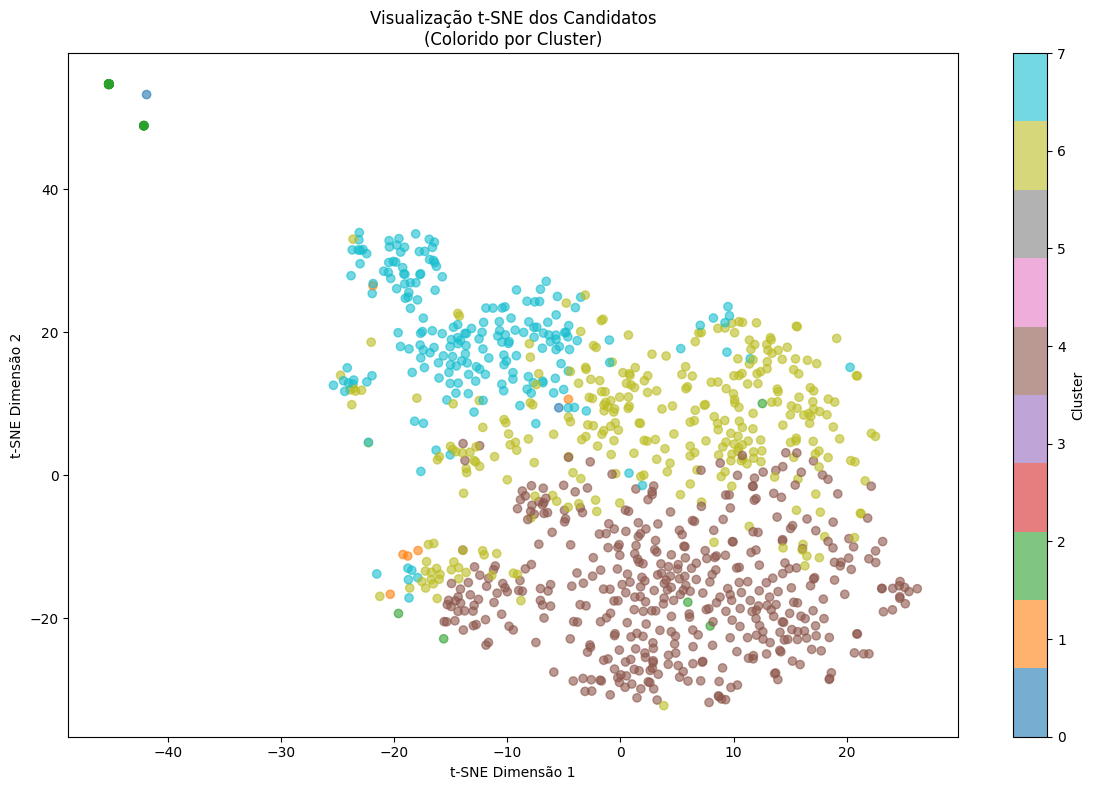

Aplicando t-SNE para vagas...


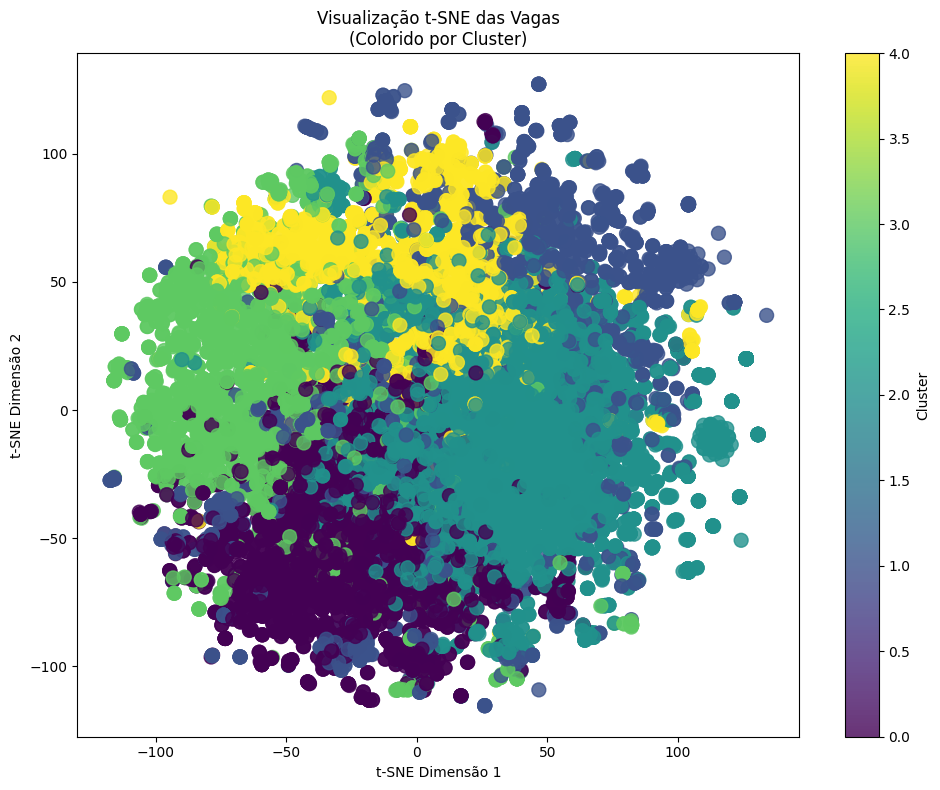

In [22]:
# Aplicar t-SNE para visualização em 2D
def apply_tsne(embeddings, n_components=2, random_state=42, perplexity=30):
    """
    Aplica t-SNE para redução de dimensionalidade
    """
    # Ajustar perplexity se necessário
    max_perplexity = min(perplexity, (len(embeddings) - 1) // 3)
    perplexity = min(perplexity, max_perplexity)

    tsne = TSNE(n_components=n_components, random_state=random_state, perplexity=perplexity)
    embeddings_2d = tsne.fit_transform(embeddings)
    return embeddings_2d

# Aplicar t-SNE apenas se tivermos dados suficientes
if len(candidate_embeddings) > 50:
    print("Aplicando t-SNE para candidatos...")
    candidate_tsne = apply_tsne(candidate_embeddings[:1000])  # Limitar para performance

    # Visualizar candidatos com cores por cluster
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(candidate_tsne[:, 0], candidate_tsne[:, 1],
                         c=candidate_clusters[:1000], cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Cluster')
    plt.title('Visualização t-SNE dos Candidatos\n(Colorido por Cluster)')
    plt.xlabel('t-SNE Dimensão 1')
    plt.ylabel('t-SNE Dimensão 2')
    plt.tight_layout()
    plt.show()

if len(job_embeddings) > 10:
    print("Aplicando t-SNE para vagas...")
    job_tsne = apply_tsne(job_embeddings, perplexity=min(10, len(job_embeddings)//3))

    # Visualizar vagas com cores por cluster
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(job_tsne[:, 0], job_tsne[:, 1],
                         c=job_clusters, cmap='viridis', alpha=0.8, s=100)
    plt.colorbar(scatter, label='Cluster')
    plt.title('Visualização t-SNE das Vagas\n(Colorido por Cluster)')
    plt.xlabel('t-SNE Dimensão 1')
    plt.ylabel('t-SNE Dimensão 2')
    plt.tight_layout()
    plt.show()
else:
    print("Dados insuficientes para t-SNE")

## 12. Rede Neural para Matching

In [16]:
# Arquitetura da rede
class JobCandidateMatchingNet(nn.Module):
    def __init__(self, embedding_dim=384, hidden_dim=256):
        super(JobCandidateMatchingNet, self).__init__()
        input_dim = embedding_dim * 2
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, candidate_embedding, job_embedding):
        combined = torch.cat([candidate_embedding, job_embedding], dim=1)
        output = self.layers(combined)
        return output

# Dataset ULTRA-LEVE - processa matriz em chunks
class MatchingDatasetMinimal(Dataset):
    def __init__(self, candidate_embeddings, job_embeddings, similarity_matrix,
                 threshold=0.5, epoch_size=5000):
        """
        Dataset minimalista que processa a matriz em chunks
        """
        self.candidate_embeddings = candidate_embeddings
        self.job_embeddings = job_embeddings
        self.threshold = threshold
        self.epoch_size = epoch_size

        n_candidates, n_jobs = similarity_matrix.shape
        print(f"Processando matriz {n_candidates}x{n_jobs} em chunks...")

        # Processar em chunks pequenos para economizar RAM
        chunk_size = 1000
        positive_samples = []
        negative_samples = []

        for i in range(0, n_candidates, chunk_size):
            end_i = min(i + chunk_size, n_candidates)
            chunk = similarity_matrix[i:end_i, :]

            # Encontrar índices no chunk
            pos = np.where(chunk > threshold)
            neg = np.where(chunk <= threshold)

            # Ajustar índices para matriz completa
            pos_pairs = np.column_stack([pos[0] + i, pos[1]])
            neg_pairs = np.column_stack([neg[0] + i, neg[1]])

            # Amostrar apenas uma fração pequena
            if len(pos_pairs) > 0:
                n_sample = min(100, len(pos_pairs))  # Apenas 100 por chunk
                idx = np.random.choice(len(pos_pairs), n_sample, replace=False)
                positive_samples.append(pos_pairs[idx])

            if len(neg_pairs) > 0:
                n_sample = min(100, len(neg_pairs))
                idx = np.random.choice(len(neg_pairs), n_sample, replace=False)
                negative_samples.append(neg_pairs[idx])

            if (i // chunk_size) % 5 == 0:
                print(f"Processado {i}/{n_candidates} candidatos...")

        # Combinar amostras
        if positive_samples:
            self.positive_indices = np.vstack(positive_samples).astype(np.int32)
        else:
            self.positive_indices = np.array([]).reshape(0, 2)

        if negative_samples:
            self.negative_indices = np.vstack(negative_samples).astype(np.int32)
        else:
            self.negative_indices = np.array([]).reshape(0, 2)

        self.n_positive = len(self.positive_indices)
        self.n_negative = len(self.negative_indices)

        print(f"Amostras positivas: {self.n_positive:,}")
        print(f"Amostras negativas: {self.n_negative:,}")

        # Limpar tudo
        del similarity_matrix, positive_samples, negative_samples
        gc.collect()

    def __len__(self):
        return self.epoch_size

    def __getitem__(self, idx):
        # Gerar par aleatório
        if np.random.random() < 0.5 and self.n_positive > 0:
            pair_idx = np.random.randint(0, self.n_positive)
            cand_idx, job_idx = self.positive_indices[pair_idx]
            label = 1.0
        elif self.n_negative > 0:
            pair_idx = np.random.randint(0, self.n_negative)
            cand_idx, job_idx = self.negative_indices[pair_idx]
            label = 0.0
        else:
            # Fallback: par aleatório qualquer
            cand_idx = np.random.randint(0, len(self.candidate_embeddings))
            job_idx = np.random.randint(0, len(self.job_embeddings))
            label = 0.0

        candidate_emb = torch.from_numpy(
            self.candidate_embeddings[cand_idx].copy()
        ).float()
        job_emb = torch.from_numpy(
            self.job_embeddings[job_idx].copy()
        ).float()
        label_tensor = torch.tensor([label], dtype=torch.float32)

        return candidate_emb, job_emb, label_tensor

# Funções de utilidade
def check_memory():
    import psutil
    ram = psutil.virtual_memory()
    gpu_mem = torch.cuda.memory_allocated(0) / 1024**3 if torch.cuda.is_available() else 0
    print(f"RAM: {ram.percent:.1f}% | GPU: {gpu_mem:.1f} GB")

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# ========== CRIAR DATASET ==========
clear_memory()
print("Status inicial:")
check_memory()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsando dispositivo: {device}")

print("\n=== Criando dataset minimalista ===")
dataset = MatchingDatasetMinimal(
    candidate_embeddings,
    job_embeddings,
    similarity_matrix,
    threshold=0.3,
    epoch_size=3000  # Reduzido ainda mais
)

print("\nStatus após criar dataset:")
check_memory()

# Dividir em treino e teste
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)


print(f"\nDataset criado: {len(dataset):,} amostras")
print("Status final:")
check_memory()

Status inicial:
RAM: 57.4% | GPU: 0.1 GB

Usando dispositivo: cuda

=== Criando dataset minimalista ===
Processando matriz 42482x14081 em chunks...
Processado 0/42482 candidatos...
Processado 5000/42482 candidatos...
Processado 10000/42482 candidatos...
Processado 15000/42482 candidatos...
Processado 20000/42482 candidatos...
Processado 25000/42482 candidatos...
Processado 30000/42482 candidatos...
Processado 35000/42482 candidatos...
Processado 40000/42482 candidatos...
Amostras positivas: 4,300
Amostras negativas: 4,300

Status após criar dataset:
RAM: 57.6% | GPU: 0.1 GB

Dataset criado: 3,000 amostras
Status final:
RAM: 57.6% | GPU: 0.1 GB


## 13. Treinamento da Rede Neural

Usando dispositivo: cuda
Iniciando treinamento...
Época 2/15, Loss: 0.4044
Época 4/15, Loss: 0.3002
Época 6/15, Loss: 0.2605
Época 8/15, Loss: 0.2515
Época 10/15, Loss: 0.2210
Época 12/15, Loss: 0.2064
Época 14/15, Loss: 0.1790


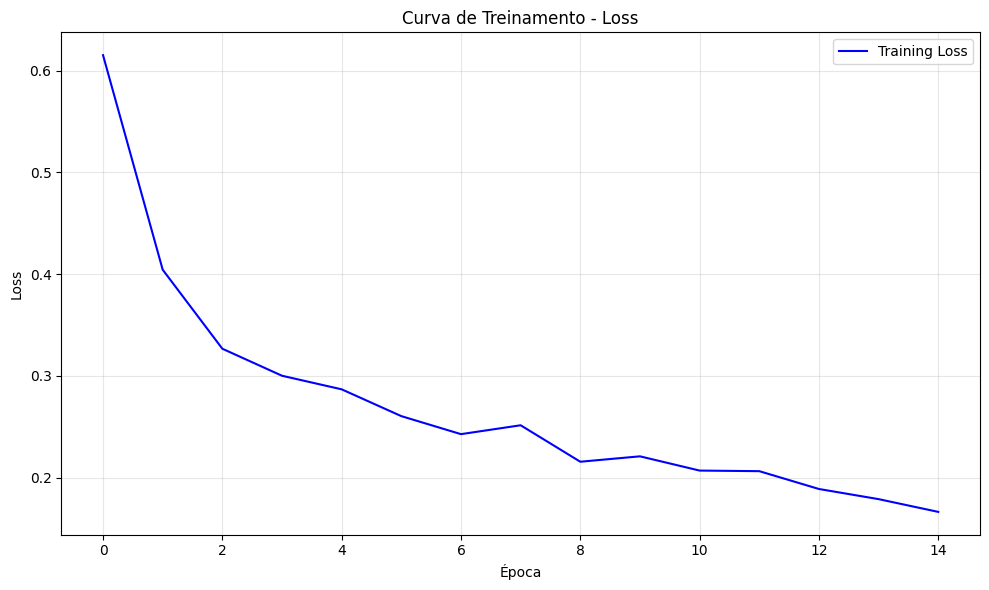

In [17]:
# Inicializar modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

model = JobCandidateMatchingNet(embedding_dim=candidate_embeddings.shape[1])
model = model.to(device)

# Definir loss e optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Função de treinamento
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for batch_idx, (candidate_emb, job_emb, labels) in enumerate(train_loader):
            candidate_emb = candidate_emb.to(device)
            job_emb = job_emb.to(device)
            labels = labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(candidate_emb, job_emb)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        if (epoch + 1) % 2 == 0:
            print(f'Época {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

    return train_losses

# Treinar modelo
if len(train_dataset) > 0:
    print("Iniciando treinamento...")
    train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=15)

    # Plotar curva de loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, 'b-', label='Training Loss')
    plt.title('Curva de Treinamento - Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Dataset insuficiente para treinamento")

## 14. Avaliação do Modelo

As métricas do modelo (AUC 0,992 etc.) são provavelmente otimistas por causa de duplo vazamento (rótulos derivados da mesma similaridade e split por par)

Avaliando modelo...

=== MÉTRICAS DE AVALIAÇÃO ===
Acurácia: 0.9650
Precisão: 0.9567
Recall: 0.9729
F1-Score: 0.9647
AUC-ROC: 0.9917


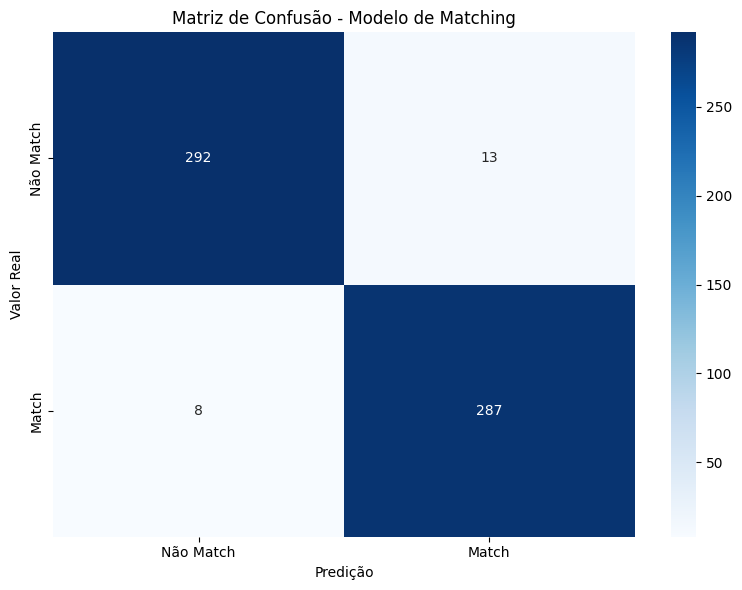

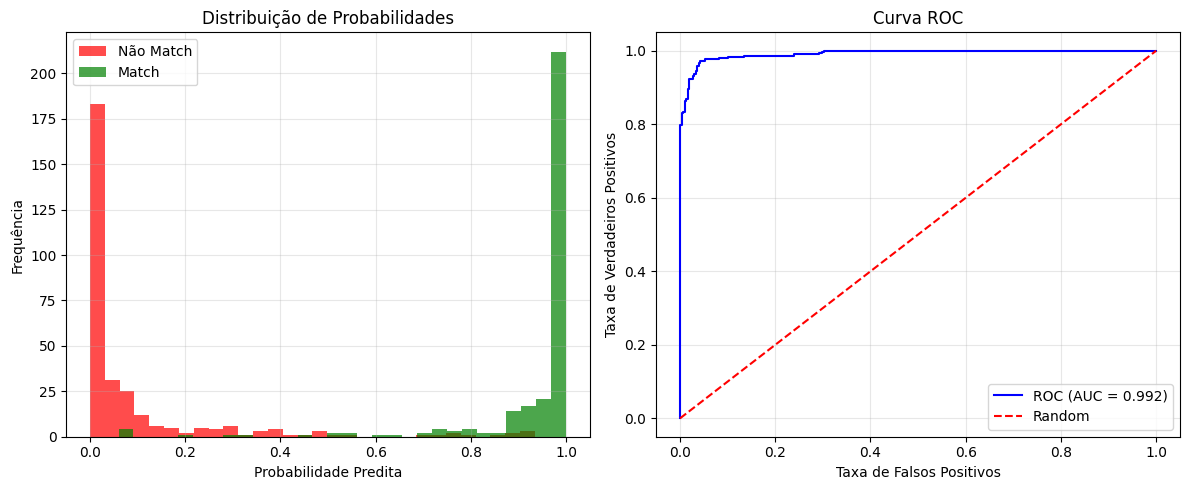

In [18]:
# Função de avaliação
def evaluate_model(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for candidate_emb, job_emb, labels in test_loader:
            candidate_emb = candidate_emb.to(device)
            job_emb = job_emb.to(device)

            outputs = model(candidate_emb, job_emb)
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predictions = np.array(predictions).flatten()
    true_labels = np.array(true_labels).flatten()

    # Converter probabilidades para classes (threshold = 0.5)
    pred_classes = (predictions > 0.5).astype(int)

    return predictions, true_labels, pred_classes

# Avaliar modelo
if len(test_dataset) > 0:
    print("Avaliando modelo...")
    predictions, true_labels, pred_classes = evaluate_model(model, test_loader, device)

    # Métricas de avaliação
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

    accuracy = accuracy_score(true_labels, pred_classes)
    precision = precision_score(true_labels, pred_classes)
    recall = recall_score(true_labels, pred_classes)
    f1 = f1_score(true_labels, pred_classes)
    auc = roc_auc_score(true_labels, predictions)

    print("\n=== MÉTRICAS DE AVALIAÇÃO ===")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

    # Matriz de confusão
    cm = confusion_matrix(true_labels, pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Não Match', 'Match'],
                yticklabels=['Não Match', 'Match'])
    plt.title('Matriz de Confusão - Modelo de Matching')
    plt.ylabel('Valor Real')
    plt.xlabel('Predição')
    plt.tight_layout()
    plt.show()

    # Distribuição de probabilidades preditas
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(predictions[true_labels == 0], bins=30, alpha=0.7, label='Não Match', color='red')
    plt.hist(predictions[true_labels == 1], bins=30, alpha=0.7, label='Match', color='green')
    plt.xlabel('Probabilidade Predita')
    plt.ylabel('Frequência')
    plt.title('Distribuição de Probabilidades')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(true_labels, predictions)

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, 'b-', label=f'ROC (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("Dataset de teste insuficiente para avaliação")

## 15. Sistema de Recomendação Inteligente

In [19]:
# Função para recomendação usando o modelo treinado
def smart_recommendation(model, candidate_embedding, job_embeddings, job_texts, top_k=10, threshold=0.5):
    """
    Recomendação inteligente usando o modelo de deep learning
    """
    model.eval()
    scores = []

    candidate_tensor = torch.FloatTensor(candidate_embedding).unsqueeze(0).to(device)

    with torch.no_grad():
        for job_emb in job_embeddings:
            job_tensor = torch.FloatTensor(job_emb).unsqueeze(0).to(device)
            score = model(candidate_tensor, job_tensor).cpu().numpy()[0][0]
            scores.append(score)

    # Ordenar por score
    job_indices = np.argsort(scores)[::-1]

    recommendations = []
    for idx in job_indices[:top_k]:
        if scores[idx] >= threshold:
            recommendations.append({
                'job_id': job_texts[idx]['job_id'],
                'ml_score': scores[idx],
                'job_text_preview': job_texts[idx]['text'][:200] + "..."
            })

    return recommendations

# Exemplo de recomendação inteligente
if len(test_dataset) > 0 and len(candidate_embeddings) > 0:
    print("=== SISTEMA DE RECOMENDAÇÃO INTELIGENTE ===")
    print("\nRecomendações para o primeiro candidato:")

    smart_recs = smart_recommendation(model, candidate_embeddings[0], job_embeddings, job_texts, top_k=5, threshold=0.3)

    if smart_recs:
        for i, rec in enumerate(smart_recs, 1):
            print(f"{i}. Vaga {rec['job_id']} - Score ML: {rec['ml_score']:.4f}")
            print(f"   Preview: {rec['job_text_preview'][:100]}...\n")
    else:
        print("Nenhuma vaga atende ao threshold mínimo")
else:
    print("Modelo não disponível para recomendações")

=== SISTEMA DE RECOMENDAÇÃO INTELIGENTE ===

Recomendações para o primeiro candidato:
1. Vaga 13822 - Score ML: 0.9999
   Preview: Vaga: 1343 ESPECIALISTA ESCRITORIO DE PROJETOS
Modelo de trabalho: 2x na semana no Escritório (segun...

2. Vaga 14072 - Score ML: 0.9999
   Preview: 06 meses iniciais de projeto
Atuação Hibrido, (maior parte vai ser remota com algumas poucas visitas...

3. Vaga 6568 - Score ML: 0.9999
   Preview: Cadastro faturas no SAP. Revisão e validação de informações fiscais e dados obrigatórios para notas ...

4. Vaga 9332 - Score ML: 0.9999
   Preview: O profissional atuará como ponto de apoio da equipe de treinamento e efetivando as atividades pertin...

5. Vaga 12838 - Score ML: 0.9999
   Preview: Vaga: SAP PP Sênior ( Analista Funcional)

Disponibilidade para viagens: Em 30 % do tempo ( Fortalez...



## 16. Análise de Características dos Clusters

In [20]:
# Função para extrair palavras-chave dos clusters
def analyze_cluster_keywords(texts, clusters, n_clusters, top_words=10):
    """
    Analisa as palavras-chave mais comuns em cada cluster
    """
    from collections import defaultdict
    from sklearn.feature_extraction.text import TfidfVectorizer

    cluster_keywords = {}

    for cluster_id in range(n_clusters):
        # Textos do cluster
        cluster_texts = [texts[i] for i, c in enumerate(clusters) if c == cluster_id]

        if cluster_texts:
            # Combinar textos do cluster
            combined_text = ' '.join(cluster_texts)

            # TF-IDF para extrair palavras importantes
            vectorizer = TfidfVectorizer(max_features=100, stop_words=None, ngram_range=(1, 2))

            try:
                tfidf_matrix = vectorizer.fit_transform([combined_text])
                feature_names = vectorizer.get_feature_names_out()
                scores = tfidf_matrix.toarray()[0]

                # Top palavras
                top_indices = np.argsort(scores)[::-1][:top_words]
                top_keywords = [(feature_names[i], scores[i]) for i in top_indices if scores[i] > 0]

                cluster_keywords[cluster_id] = top_keywords
            except:
                cluster_keywords[cluster_id] = []

    return cluster_keywords

# Analisar clusters de candidatos
print("=== ANÁLISE DE CLUSTERS DE CANDIDATOS ===")
candidate_clean_texts = [candidate['clean_text'] for candidate in candidate_texts]
candidate_cluster_keywords = analyze_cluster_keywords(candidate_clean_texts, candidate_clusters, 8)

for cluster_id, keywords in candidate_cluster_keywords.items():
    count = sum(1 for c in candidate_clusters if c == cluster_id)
    print(f"\nCluster {cluster_id} ({count} candidatos):")
    if keywords:
        for word, score in keywords[:5]:
            print(f"  - {word}: {score:.3f}")
    else:
        print("  - Nenhuma palavra-chave encontrada")

# Analisar clusters de vagas
print("\n=== ANÁLISE DE CLUSTERS DE VAGAS ===")
job_clean_texts = [job['clean_text'] for job in job_texts]
job_cluster_keywords = analyze_cluster_keywords(job_clean_texts, job_clusters, 5)

for cluster_id, keywords in job_cluster_keywords.items():
    count = sum(1 for c in job_clusters if c == cluster_id)
    print(f"\nCluster {cluster_id} ({count} vagas):")
    if keywords:
        for word, score in keywords[:5]:
            print(f"  - {word}: {score:.3f}")
    else:
        print("  - Nenhuma palavra-chave encontrada")

=== ANÁLISE DE CLUSTERS DE CANDIDATOS ===

Cluster 0 (4252 candidatos):
  - cwf: 0.442
  - net: 0.333
  - de: 0.324
  - consultor: 0.249
  - desenvolvedor: 0.203

Cluster 1 (1935 candidatos):
  - and: 0.548
  - oracle: 0.359
  - sap: 0.324
  - de: 0.300
  - of: 0.267

Cluster 2 (3663 candidatos):
  - de: 0.632
  - analista: 0.523
  - analista de: 0.425
  - sistemas: 0.148
  - de sistemas: 0.146

Cluster 3 (2280 candidatos):
  - de: 0.523
  - projetos: 0.381
  - de projetos: 0.374
  - gerente: 0.306
  - gerente de: 0.299

Cluster 4 (12746 candidatos):
  - de: 0.934
  - em: 0.149
  - do: 0.131
  - para: 0.115
  - da: 0.096

Cluster 5 (748 candidatos):
  - java: 0.790
  - java java: 0.597
  - programador: 0.065
  - programador java: 0.060
  - desenvolvedor: 0.056

Cluster 6 (10158 candidatos):
  - de: 0.926
  - em: 0.174
  - do: 0.114
  - para: 0.114
  - com: 0.091

Cluster 7 (6700 candidatos):
  - de: 0.872
  - em: 0.188
  - and: 0.155
  - desenvolvimento: 0.124
  - com: 0.122

=== ANÁLI

## 17. Conclusões e Próximos Passos

### Principais Diferenciais desta Abordagem:

1. **Foco em Dados Textuais**: Utilizamos principalmente o conteúdo textual dos CVs e descrições de vagas
2. **Embeddings Semânticos**: Representações vetoriais que capturam o significado do texto
3. **Similaridade Semântica**: Matching baseado na similaridade de significado, não apenas palavras-chave
4. **Deep Learning**: Rede neural para aprender padrões complexos de matching
5. **Clustering Semântico**: Agrupamento baseado em similaridade semântica

### Vantagens desta Abordagem:
- Captura nuances semânticas do texto
- Menos dependente de features engineered
- Escalável para novos dados
- Interpreta melhor texto não estruturado

### Próximos Passos:
- Integrar dados estruturados com embeddings
- Experimentar com modelos BERT específicos para português
- Implementar ranking learning
- Adicionar explicabilidade ao modelo
- Criar interface para recomendações em tempo real

In [43]:
# Definir o diretório de destino no Google Drive
drive_save_dir = '/content/drive/MyDrive/fiap/tech-challenge-f5/model'
import os

# Criar o diretório no Drive se não existir
if not os.path.exists(drive_save_dir):
    os.makedirs(drive_save_dir)
    print(f"Diretório '{drive_save_dir}' criado no Google Drive.")
else:
    print(f"Diretório '{drive_save_dir}' já existe no Google Drive.")


# Salvar modelo e embeddings para uso futuro
import joblib

# Salvar modelo treinado localmente e no Drive
if len(test_dataset) > 0:
    torch.save(model.state_dict(), 'job_matching_neural_model.pth')
    torch.save(model.state_dict(), os.path.join(drive_save_dir, 'job_matching_neural_model.pth'))
    print("Modelo neural salvo localmente e no Google Drive como 'job_matching_neural_model.pth'")

# Salvar embeddings localmente e no Drive
np.save('candidate_embeddings.npy', candidate_embeddings)
np.save(os.path.join(drive_save_dir, 'candidate_embeddings.npy'), candidate_embeddings)
np.save('job_embeddings.npy', job_embeddings)
np.save(os.path.join(drive_save_dir, 'job_embeddings.npy'), job_embeddings)
print("Embeddings salvos localmente e no Google Drive como arquivos .npy")

# Salvar dados de texto processados localmente e no Drive
joblib.dump(candidate_texts, 'candidate_texts_processed.joblib')
joblib.dump(candidate_texts, os.path.join(drive_save_dir, 'candidate_texts_processed.joblib'))
joblib.dump(job_texts, 'job_texts_processed.joblib')
joblib.dump(job_texts, os.path.join(drive_save_dir, 'job_texts_processed.joblib'))
print("Dados de texto processados salvos localmente e no Google Drive")

print("\n=== NOTEBOOK CONCLUÍDO ===")
print("Abordagem de Deep Learning e NLP para matching de vagas implementada com sucesso!")

Diretório '/content/drive/MyDrive/fiap/tech-challenge-f5/model' já existe no Google Drive.
Modelo neural salvo localmente e no Google Drive como 'job_matching_neural_model.pth'
Embeddings salvos localmente e no Google Drive como arquivos .npy
Dados de texto processados salvos localmente e no Google Drive

=== NOTEBOOK CONCLUÍDO ===
Abordagem de Deep Learning e NLP para matching de vagas implementada com sucesso!
